In [1]:
import os
import math
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, SGDClassifier
from sklearn import model_selection
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics.pairwise import cosine_similarity
import pubchempy as pcp
os.chdir('../')
from util.util import *
os.chdir('notebooks')


import IPython.display as Disp

In what ways are the linolein test example and phthalates similar? Are there properties that linolein and phthalates share but phthalates and the pubchem organics do not?

In [2]:
pl_full = pd.read_pickle('../database/plasticizer_data_v9_top_similar.pkl')
org_full = pd.read_pickle('../data/pubchem/org_desc_fps_v3.pkl')
linolein = pd.read_pickle('../data/pubchem/linolein_test.pkl')
linolein.columns = [str(col) for col in linolein.columns]
linolein = linolein[pl_full.columns[1:]]

In [3]:
features = pl_full.columns[1:146].to_list()
pl_prop = pl_full[features].to_numpy()
org_prop = org_full[features].to_numpy()
lin_prop = linolein[features].to_numpy()

In [4]:
pl_prop.shape

(71, 145)

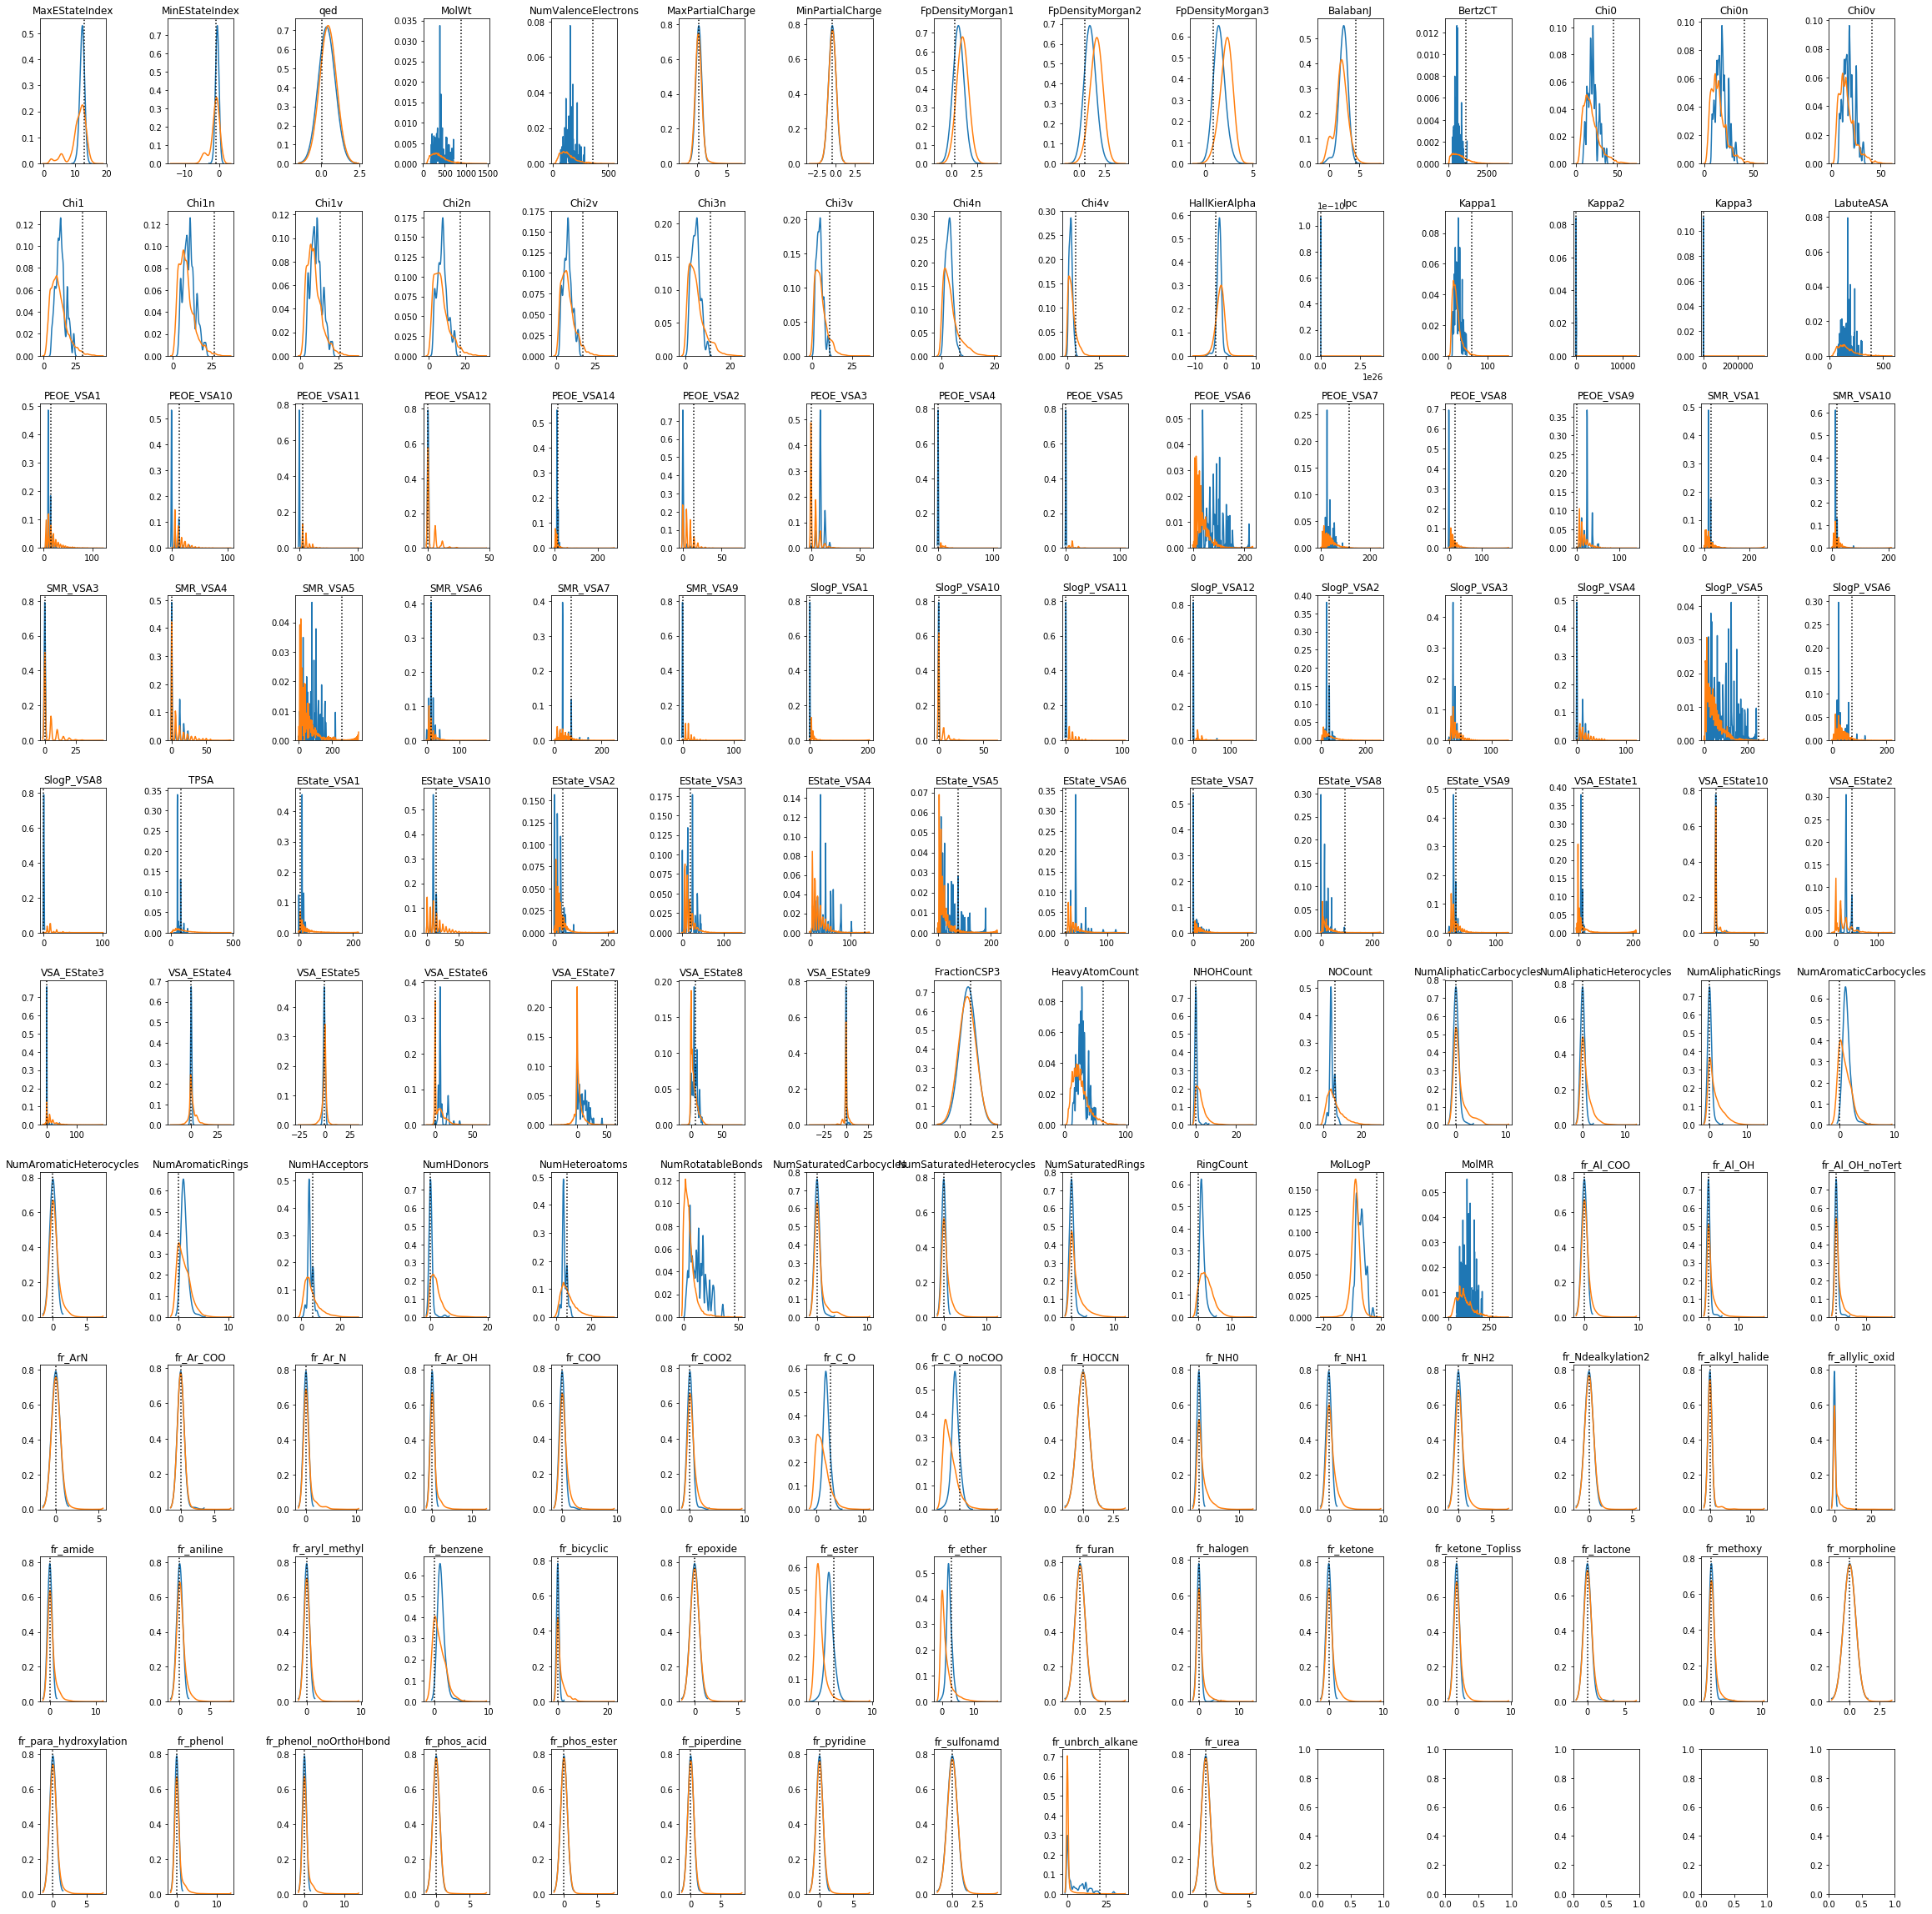

In [5]:
fig, ax = plt.subplots(10,15,figsize=(32,32))

for i, ax in enumerate(fig.axes):
    if i < 145:
        try:
            feat = features[i]
            sns.distplot(pl_prop[:,features.index(feat)], hist=False, ax=ax, kde_kws={'bw':0.5})
            sns.distplot(org_prop[:,features.index(feat)], hist=False, ax=ax, kde_kws={'bw':0.5})
            ax.axvline(lin_prop[:,features.index(feat)], c='black', ls=':')
            ax.set_title(feat)
        except RuntimeError:
            pass
fig.tight_layout()
plt.savefig('lin.png')

Do the phthalates and 'other' plasticizers have properties in common that are unique to them and not all pubchem organic molecules?

In [6]:
pl_og = pd.read_pickle('../database/plasticizer_data_v8_desc_fps.pkl')
og_smiles = pl_og['SMILES'].to_numpy()
top_sim_smiles = pl_full['SMILES'].to_numpy()
og_idxs = []
for i, smile in enumerate(og_smiles):
    if smile in top_sim_smiles:
        pass
    else:
        og_idxs.append(i)
pl_og = pl_og.iloc[og_idxs]
og_prop = pl_og[pl_og.columns[1:146]].to_numpy()

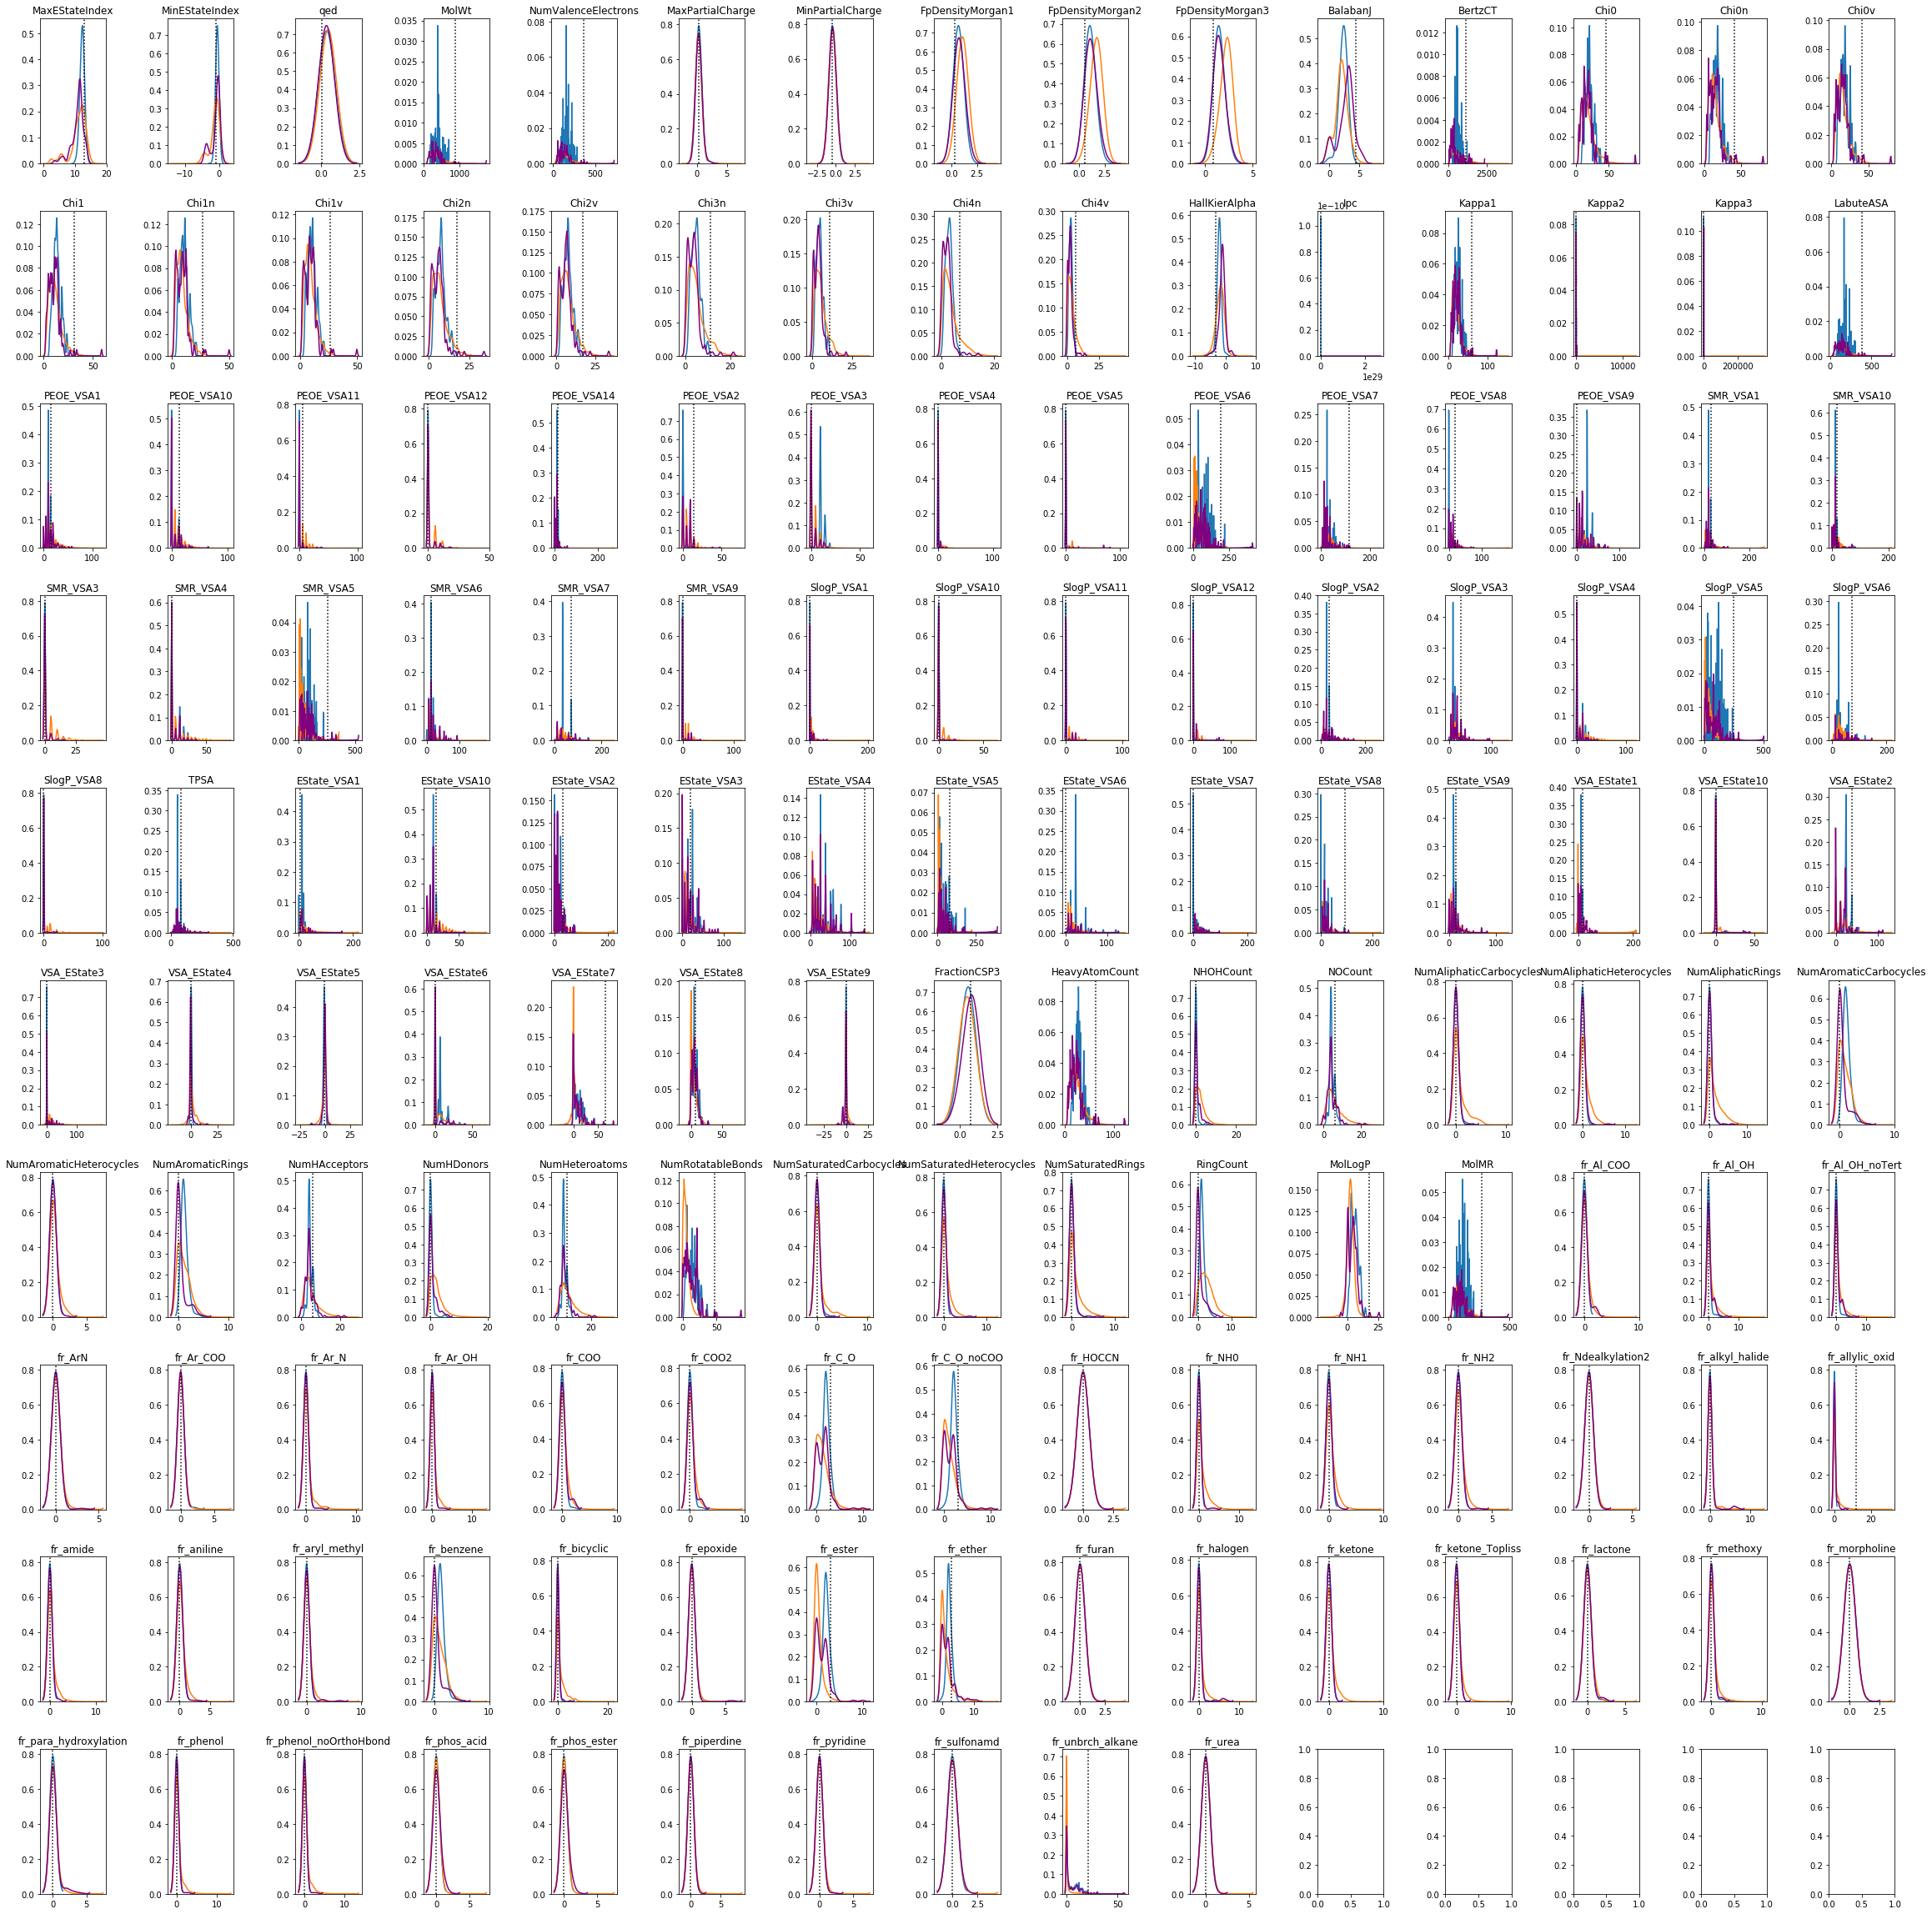

In [7]:
fig, ax = plt.subplots(10,15,figsize=(32,32))

for i, ax in enumerate(fig.axes):
    if i < 145:
        try:
            feat = features[i]
            sns.distplot(pl_prop[:,features.index(feat)], hist=False, ax=ax, kde_kws={'bw':0.5})
            sns.distplot(org_prop[:,features.index(feat)], hist=False, ax=ax, kde_kws={'bw':0.5})
            sns.distplot(og_prop[:,features.index(feat)], hist=False, ax=ax, kde_kws={'bw':0.5}, color='purple')
            ax.axvline(lin_prop[:,features.index(feat)], c='black', ls=':')
            ax.set_title(feat)
        except RuntimeError:
            pass
fig.tight_layout()
plt.savefig('lin+other.png')

Phthalate, non-phthalate plasticizers and pubchem organic molecules for the most part have similar property distributions. I think choosing properties in an automated fashion is basically shooting in the dark and a dead end. Need to define some hand-selected properties and see if we can:
1. Group our set of plasticizers tighter in PC space
2. Differentiate between plasticizers and random organic molecules
3. Predict epoxided esters to be plasticizers without training on them

Exploring the functional groups identified by RDKit

In [14]:
pl_full = pd.read_pickle('../database/plasticizer_data_v6_desc_fps.pkl')
pl_full.columns = [str(x) for x in pl_full.columns]

In [52]:
fr_cols = []
for col in pl_full.columns:
    if 'fr' in col:
        fr_cols.append(col)
n_groups = []
for col in fr_cols:
    if 'N' in col or col in ['fr_amide', 'fr_urea']:
        n_groups.append(col)

In [57]:
pl_groups = pl_full[fr_cols]
pl_smiles = pl_full['SMILES'].to_numpy()

### Remove smiles with multiple components
pure_smiles = []
for smile in pl_smiles:
    if '.' in smile:
        pass
    else:
        pure_smiles.append(smile)

In [77]:
non_polar = ['fr_C_O_noCOO', 'fr_ester', 'fr_Al_OH_noTert', 'fr_unbrch_alkane', 'fr_benzene', \
             'fr_bicyclic', 'fr_phos_ester', 'fr_methoxy', 'fr_allylic_oxid', 'fr_aryl_methyl', \
             'fr_lactone', 'fr_Al_COO', 'fr_COO', 'fr_COO2', 'fr_alkyl_halide', 'fr_phenol', \
             'fr_phenol_noOrthoHbond', 'fr_morpholine', 'fr_ketone', 'fr_ketone_Topliss', \
             'fr_aniline', 'fr_pyridine', 'fr_epoxide', 'fr_piperdine'] + n_groups

polar = ['fr_C_O', 'fr_ether', 'fr_Al_OH', 'fr_phos_acid', 'fr_para_hydroxylation', \
         'fr_sulfonamd', 'fr_halogen', 'fr_Ar_OH']

for i, row in pl_groups.iterrows():
    present_groups = []
    freqs = []
    for col in fr_cols:
        if col not in non_polar and col not in polar:
            if row[col] != 0:
                present_groups.append(col)
                freqs.append(row[col])
            else:
                pass
        else:
            pass
    if len(present_groups) > 0:
        if pl_smiles[i] in pure_smiles:
            print(pl_smiles[i], present_groups, freqs)

Exploring polarity calculations

In [321]:
pl_pol = pd.read_pickle('../database/plasticizer_data_v10_polarity.pkl')
pl_cats = pd.read_pickle('../database/plasticizer_data_v6_desc_fps.pkl')
org_pol = pd.read_pickle('../data/pubchem/org_polarity_v2.pkl')

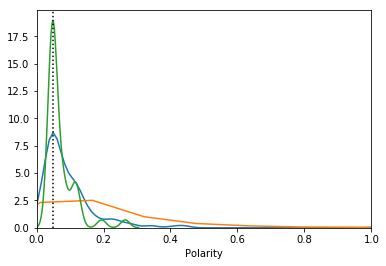

In [322]:
sns.distplot(pl_pol['Polarity'], hist=False)
sns.distplot(org_pol['Polarity'], hist=False)
sns.distplot(pl_pol[pl_cats['Chemical Category'] == 'Phthalates']['Polarity'], hist=False)
plt.axvline(0.048856, c='black', ls=':')
plt.xlim([0,1])
plt.show()

The polarity parameter looks promising. I think we can use this in tandem with the RDKit parameters and LASSO to select a reduced number of physicochemical descriptors to use.

In [323]:
pl_pol = pd.concat([pl_pol[pl_pol.columns[1:195]], pl_pol['Polarity']], axis=1)
all_cols = pl_prop.columns.to_numpy()

pl_prop = pl_pol[all_cols]
org_prop = org_pol[all_cols]

In [324]:
lin_data = pd.read_pickle('../data/pubchem/linolein_test.pkl')
lin_data['Polarity'] = 0.048856
lin_prop = lin_data[all_cols]

In [325]:
# Run lasso a few times and save averaged model

n = 100
w_avg = np.zeros((n, pl_prop.shape[1]+1))
pl_train_accs = []
pl_test_accs = []
org_train_accs = []
org_test_accs = []
lin_avgs = []
for i in range(n):
    org_data = org_prop.sample(n=210).to_numpy()
    pl_data = pl_prop.to_numpy()
    lin_data = lin_prop.to_numpy()
    pl_data = np.concatenate([pl_data, np.ones((210,1))], axis=1)
    org_data = np.concatenate([org_data, np.zeros((210,1))], axis=1)

    rand_idxs = np.random.choice(np.arange(pl_data.shape[0]), size=pl_data.shape[0])
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]
    pl_train = pl_data[train_idxs,:]
    pl_test = pl_data[test_idxs,:]

    rand_idxs = np.random.choice(np.arange(pl_data.shape[0]), size=pl_data.shape[0])
    train_idxs = rand_idxs[:168]
    test_idxs = rand_idxs[168:]
    org_train = org_data[train_idxs,:]
    org_test = org_data[test_idxs,:]

    train_data = np.concatenate([pl_train, org_train])
    test_data = np.concatenate([pl_test, org_test])
    np.random.shuffle(train_data)
    np.random.shuffle(test_data)
    X_train = train_data[:,:-1]
    y_train = train_data[:,-1]
    X_test = test_data[:,:-1]
    y_test = test_data[:,-1]
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    lin_data = scaler.transform(lin_data)
    clf = LogisticRegression(solver='liblinear', penalty='l1')
    clf.fit(X_train, y_train)

    pl_train = scaler.transform(pl_train[:,:-1])
    pl_test = scaler.transform(pl_test[:,:-1])
    org_train = scaler.transform(org_train[:,:-1])
    org_test = scaler.transform(org_test[:,:-1])
    lin_data = scaler.transform(lin_data)
    pl_train_accs.append(clf.score(pl_train, np.ones((168,1))))
    pl_test_accs.append(clf.score(pl_test, np.ones((42,1))))
    org_train_accs.append(clf.score(org_train, np.zeros((168,1))))
    org_test_accs.append(clf.score(org_test, np.zeros((42,1))))
    lin_avgs.append(clf.predict_proba(lin_data)[0][1])
    w_avg[i,:-1] = clf.coef_[0,:]
    w_avg[i,-1] = clf.intercept_[0]
    
w_avg = np.mean(w_avg, axis=0)
print('Train Acc PL - {}%  '.format(round(np.mean(pl_train_accs)*100, 2)) + \
      'Test Acc PL - {}%  '.format(round(np.mean(pl_test_accs)*100,2)) + \
      'Train Acc ORG - {}%  '.format(round(np.mean(org_train_accs)*100,2)) + \
      'Test Acc ORG - {}%  '.format(round(np.mean(org_test_accs)*100,2)) + \
      'Linolein Confidence - {}%'.format(round(np.mean(lin_avgs)*100,2)))

Train Acc PL - 94.51%  Test Acc PL - 91.98%  Train Acc ORG - 95.13%  Test Acc ORG - 91.24%  Linolein Confidence - 95.25%


The logistic regression gets good accuracies and is also confident that the epoxidized ester is also a plasticizer. Last thing I want to try before moving on to generative algorithms is the Multivariate Gaussian Outlier Detection (given an explained variance PCA cutoff)

In [379]:
def estimateGaussian(X):
    n = np.size(X, 1)
    m = np.size(X, 0)
    mu = np.zeros((n, 1))
    sigma2 = np.zeros((n, 1))
    
    mu = np.reshape((1/m)*np.sum(X, 0), (1, n))
    sigma2 = np.reshape((1/m)*np.sum(np.power((X - mu),2), 0),(1, n))
    
    return mu, sigma2

def multivariateGaussian(X, mu, sigma2):
     n = np.size(sigma2, 1)
     m = np.size(sigma2, 0)
     #print(m,n)
     
     if n == 1 or m == 1:
        # print('Yes!')
         sigma2 = np.diag(sigma2[0, :])
     #print(sigma2)
     X = X - mu
     pi = math.pi
     det = np.linalg.det(sigma2)
     inv = np.linalg.inv(sigma2)
     val = np.reshape((-0.5)*np.sum(np.multiply((X@inv),X), 1),(np.size(X, 0), 1))
     #print(val.shape)
     p = np.power(2*pi, -n/2)*np.power(det, -0.5)*np.exp(val)
     
     return p

def selectThreshHold(yval, pval):
    F1 = 0
    bestF1 = 0
    bestEpsilon = 0

    stepsize = (np.max(pval) - np.min(pval))/1000

    epsVec = np.arange(np.min(pval), np.max(pval), stepsize)
    noe = len(epsVec)

    for eps in range(noe):
        epsilon = epsVec[eps]
        pred = (pval < epsilon)
        prec, rec = 0,0
        tp,fp,fn = 0,0,0

        try:
            for i in range(np.size(pval,0)):
                if pred[i] == 1 and yval[i] == 1:
                    tp+=1
                elif pred[i] == 1 and yval[i] == 0:
                    fp+=1
                elif pred[i] == 0 and yval[i] == 1:
                    fn+=1
            prec = tp/(tp + fp)
            rec = tp/(tp + fn)
            F1 = 2*prec*rec/(prec + rec)
            if F1 > bestF1:
                bestF1 = F1
                bestEpsilon = epsilon
        except ZeroDivisionError:
            pass        

    return bestF1, bestEpsilon

In [380]:
# PCA Model

org_data = org_prop.sample(n=210).to_numpy()
pl_data = pl_prop.to_numpy()
lin_data = lin_prop.to_numpy()

rand_idxs = np.random.choice(np.arange(pl_data.shape[0]), size=pl_data.shape[0])
train_idxs = rand_idxs[:168]
test_idxs = rand_idxs[168:]
pl_train = pl_data[train_idxs,:]
pl_test = pl_data[test_idxs,:]

rand_idxs = np.random.choice(np.arange(pl_data.shape[0]), size=pl_data.shape[0])
train_idxs = rand_idxs[:168]
test_idxs = rand_idxs[168:]
org_train = org_data[train_idxs,:]
org_test = org_data[test_idxs,:]

train_data = np.concatenate([pl_train, org_train])
test_data = np.concatenate([pl_test, org_test])
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)
lin_data = scaler.transform(lin_data)

pca = PCA(50)
train_ics = pca.fit_transform(train_data)
test_ics = pca.transform(test_data)
lin_ics = pca.transform(lin_data)

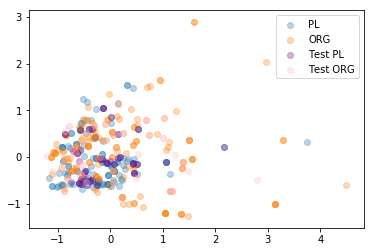

In [381]:
plt.scatter(train_ics[:168,0], train_ics[:168,1], label='PL', alpha=0.3)
plt.scatter(train_ics[168:,0], train_ics[168:,1], label='ORG', alpha=0.3)
plt.scatter(test_ics[:42,0], test_ics[:42,1], label='Test PL', alpha=0.3, c='purple')
plt.scatter(test_ics[42:,0], test_ics[42:,1], label='Test ORG', alpha=0.3, c='pink')
plt.legend(loc='best')
plt.show()

In [382]:
for i, val in enumerate(np.cumsum(pca.explained_variance_ratio_)):
    if val > 0.9:
        last_ic = i
        break

In [393]:
X_train = train_ics[:168,:last_ic]
X_test = test_ics[:,:last_ic]
lin_val = lin_ics[:,:last_ic]
y_test = np.concatenate([np.zeros((42,1)), np.ones((42,1))])

In [394]:
mu, sigma2 = estimateGaussian(X_train)
p = multivariateGaussian(X_train, mu, sigma2)
p_test = multivariateGaussian(X_test, mu, sigma2)
F1, epsilon = selectThreshHold(y_test, p_test)
epsilon

1642842.5995755745

In [395]:
p_lin = multivariateGaussian(lin_val, mu, sigma2)
p_lin

array([[1.54244896e-13]])

In [396]:
pl_anomalies = 0
org_anomalies = 0
for prob in p_test[:42]:
    if prob < epsilon:
        pl_anomalies += 1
for prob in p_test[42:]:
    if prob < epsilon:
        org_anomalies += 1
pl_anomalies, org_anomalies

(19, 41)

Even when expanding out enough ICs to explain 90% of variance the MGOD algorithm misses on almost half of test PL samples and does not think Linolein is a plasticizer. We'll roll with logistic regression and move onto generative algorithms.